## Co-moving stars in Kepler

(done in a very hacky way) (but this is probably ok because we're assuming all the stars are far away)

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from tqdm import tqdm

Load up the table, which was made with Gaia Archive xmatch:

In [3]:
kepler_table_file = '../data/kepler-result.fits'
table = Table.read(kepler_table_file, format='fits')

In [4]:
table.info

<Table masked=True length=886499>
              name                dtype        unit       n_bad 
-------------------------------- ------- ---------------- ------
                     solution_id   int64                       0
                     designation bytes28                       0
                       source_id   int64                       0
                    random_index   int64                       0
                       ref_epoch float64               yr      0
                              ra float64              deg      0
                        ra_error float64              mas      0
                             dec float64              deg      0
                       dec_error float64              mas      0
                        parallax float64              mas      0
                  parallax_error float64              mas      0
             parallax_over_error float32                       0
                            pmra float64         mas / y

In [36]:
def ppm_check(star1, star2, sigma=5.):
    """
    Returns True if the differences between parallax, pmra, and pmdec are all below 
    the sigma threshold.
    """
    names = ['parallax', 'pmra', 'pmdec']
    for name in names:
        err = np.sqrt(star1[name+'_error']**2 + star2[name+'_error']**2)
        if np.isnan(star1[name]) or np.isnan(star2[name]) or np.isnan(err):
            return False
        if (np.abs(star1[name] - star2[name])/err) >= sigma:
            return False
    return True

In [49]:
def make_x(star):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    x = np.zeros(len(names))
    for i, name in enumerate(names):
        x[i] = star[name]
    return x

def make_cov(star):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.zeros((len(names), len(names)))
    for i, name1 in enumerate(names):
        err = star[name1+'_error']
        C[i, i] = err ** 2
        for j, name2 in enumerate(names):
            if j <= i:
                continue
            corr = star["{0}_{1}_corr".format(name1, name2)]
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

def chisq(star1, star2):
    """
    calculates chisquared for two stars based on their parallax and 2D proper motions
    """
    deltax = make_x(star1) - make_x(star2)
    cplusc = make_cov(star1) + make_cov(star2)
    return np.dot(deltax, np.linalg.solve(cplusc, deltax))

In [38]:
all_names = np.unique(table['kepid'].data.data)
tested_pair_ids = []
chisqs = []
for k in tqdm(all_names[:100]):
    matches = table['kepid'] == k
    primary_match = table[matches][0]
    other_matches = table[matches][1:]
    for m in other_matches:
        if ppm_check(primary_match, m):
            tested_pair_ids.append((primary_match['source_id'], m['source_id']))
            chisqs.append(chisq(primary_match, m))
            
tested_pair_ids = np.asarray(tested_pair_ids)
chisqs = np.asarray(chisqs)

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


(array([73., 68., 32., 22., 11.,  7.,  2.,  2.,  2.,  1.]),
 array([ 0.16667109,  5.31813244, 10.46959378, 15.62105513, 20.77251648,
        25.92397782, 31.07543917, 36.22690052, 41.37836187, 46.52982321,
        51.68128456]),
 <a list of 10 Patch objects>)

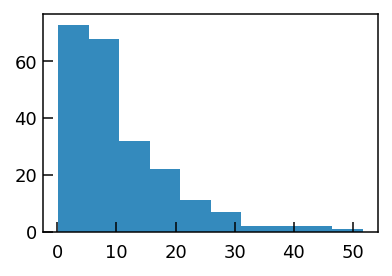

In [48]:
plt.hist(chisqs)

In [47]:
len(all_names)

199891